***Importing Libraries***

In [2]:
import pandas as pd
import sqlalchemy
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

***Converting xlsx to DataFrame***

In [3]:
# Converting Excel file into a Dataframe
main_data = pd.read_excel(r'D:\Projects\Guvi Project 3\FAOSTAT_data.xlsx')

***Data Handling and Preprocessing***

In [4]:
#Droping unwanted columns
main_data.drop(columns='Flag',inplace=True)

main_data.drop(columns='Flag Description',inplace=True)

main_data.drop(columns='Note',inplace=True)

main_data.drop(columns='Year Code',inplace=True)

In [5]:
#Checking null values
main_data.isna().sum()

Domain Code           0
Domain                0
Area Code (M49)       0
Area                  0
Element Code          0
Element               0
Item Code (CPC)       5
Item                  0
Year                  0
Unit                  2
Value              6517
dtype: int64

In [6]:
IC_null = main_data[main_data['Item Code (CPC)'].isna()]

In [7]:
IC_check= main_data[(main_data['Area']== 'Afghanistan') & (main_data['Item']=='Oranges')]


In [8]:
# Forward filling for item code column
main_data['Item Code (CPC)'] = main_data['Item Code (CPC)'].ffill()

# Check for missing 'Unit' values
missing_units = main_data[main_data['Unit'].isna()]


In [9]:
# Find indexes of NaN values in a "Unit" column
unit_index = main_data[main_data["Unit"].isna()].index

In [10]:
# Replace NaN at specific positions with different values
main_data.loc[unit_index[0], "Unit"] = "t"
main_data.loc[unit_index[1], "Unit"] = "kg/ha"

**Handling values column**

In [11]:
nan_value=main_data[main_data['Value'].isna()]

In [12]:
# Droping null value rows
data=main_data.dropna()

In [13]:
#Checking null values
data.isna().sum()

Domain Code        0
Domain             0
Area Code (M49)    0
Area               0
Element Code       0
Element            0
Item Code (CPC)    0
Item               0
Year               0
Unit               0
Value              0
dtype: int64

In [14]:
# Dropping rows with '1000 No'
data = data.loc[data['Unit'] != '1000 No']

In [15]:
# Filtering rows with elemets 'Area harvested', 'Yield','Production'. 
data_fil = data[data['Element'].isin(['Area harvested', 'Yield','Production'])]

***Transforming dataset***

In [16]:
# selecting columns for transform
pre_transform=data_fil[['Domain Code','Domain','Area Code (M49)','Element','Area','Item Code (CPC)','Item','Year','Value']]

In [17]:
df_transformed = pre_transform.pivot_table(
    index=["Domain Code", "Domain", "Area Code (M49)", "Area", "Item Code (CPC)", 
           "Item","Year"],
    columns="Element",
    values="Value",
    aggfunc="first"  # Use 'first' to avoid aggregation issues
).reset_index()

In [18]:
#Cheacking null values
df_transformed.isna().sum()

Element
Domain Code            0
Domain                 0
Area Code (M49)        0
Area                   0
Item Code (CPC)        0
Item                   0
Year                   0
Area harvested     34219
Production           224
Yield              31547
dtype: int64

In [19]:
# Identifying rows where production is not monitored
no_production = df_transformed[df_transformed['Production'].isna()]

In [20]:
# Drop rows with no production
Cleaned_Data = df_transformed.dropna(subset=['Production'])

In [21]:
#selecting columns
Cleaned_Data_complete=Cleaned_Data[['Area','Item','Year','Area harvested',
                   'Yield','Production']]

In [22]:
#Droping rows with null values
Cleaned_Data_final=Cleaned_Data_complete.dropna()

**Final dataset**

In [23]:
Cleaned_Data_final.columns

Index(['Area', 'Item', 'Year', 'Area harvested', 'Yield', 'Production'], dtype='object', name='Element')

In [24]:
#checking duplicates
print(Cleaned_Data_final.duplicated().sum())

0


In [25]:
#checking null values
Cleaned_Data_final.isna().sum()

Element
Area              0
Item              0
Year              0
Area harvested    0
Yield             0
Production        0
dtype: int64

In [26]:
Cleaned_Data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44979 entries, 2 to 81975
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            44979 non-null  object 
 1   Item            44979 non-null  object 
 2   Year            44979 non-null  int64  
 3   Area harvested  44979 non-null  float64
 4   Yield           44979 non-null  float64
 5   Production      44979 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.4+ MB


**Transferring Data to SQL**

In [27]:
from sqlalchemy import create_engine

host = "localhost"
port = "5432"
username = "postgres" 
password = "reyvan"
db_name = "Crop_data"

connector = f"postgresql://{username}:{password}@{host}:{port}/{db_name}" # must follow this syntax

engine = create_engine(connector)

table_name = "FAO_data"

Cleaned_Data_final.to_sql(table_name, engine, if_exists="replace", index=False)

print("Data Transferred Successfully")


Data Transferred Successfully


In [28]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection parameters
host = "localhost"
port = "5432"
username = "postgres"
password = "reyvan"
db_name = "Crop_data"

connector = f"postgresql://{username}:{password}@{host}:{port}/{db_name}" # must follow this syntax

engine = create_engine(connector)

# Query to check if the table exists
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""

# Read data from the query into a DataFrame
df_tables = pd.read_sql_query(query, engine)

# Display the list of tables
print(df_tables)


  table_name
0   FAO_data


In [29]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection parameters
host = "localhost"
port = "5432"
username = "postgres"
password = "reyvan"
db_name = "Crop_data"

connector = f"postgresql://{username}:{password}@{host}:{port}/{db_name}" # must follow this syntax

engine = create_engine(connector)

# Table name to verify
table_name = "FAO_data"

# Query to retrieve data from the table
query = f'SELECT * FROM "{table_name}" LIMIT 5;'

# Read data from the table into a DataFrame
df = pd.read_sql_query(query, engine)

# Display the retrieved data
print(df)


          Area   Item  Year  Area harvested   Yield  Production
0  Afghanistan  Wheat  2019       2334000.0  2095.1   4890000.0
1  Afghanistan  Wheat  2020       2668000.0  1943.4   5185000.0
2  Afghanistan  Wheat  2021       2046564.0  1963.1   4017657.0
3  Afghanistan  Wheat  2022       1859339.0  2045.3   3802895.0
4  Afghanistan  Wheat  2023       2003070.0  2146.7   4300000.0


***EDA***

Analyze Crop Distribution

In [30]:
#Crop Types
ct=Cleaned_Data_final['Item'].value_counts(ascending=False).reset_index(name='Cultivation_count')
top10_max=ct.head(10)

In [31]:
ct_min=Cleaned_Data_final['Item'].value_counts(ascending=True).reset_index(name='Cultivation_count')
top10_min=ct_min.head(10)

In [32]:
max_crop=px.bar(top10_max,x='Item',y='Cultivation_count')
max_crop.update_layout(title='Maximum cultivated items during the year 2019 to 2023')
max_crop.show()

In [33]:
min_crop=px.bar(top10_min,x='Item',y='Cultivation_count')
min_crop.update_layout(title='Minimum cultivated items during the year 2019 to 2023')
min_crop.show()

In [34]:
#Geographical Distribution

gd=Cleaned_Data_final[['Area','Item']]

In [35]:
gd_analysis=gd.value_counts().reset_index(name='cultivated_count')

In [36]:
 #idxmax() - to find highest cultivated crop type in each country
gd_most = gd_analysis.loc[gd_analysis.groupby("Area")["cultivated_count"].idxmax()] 

In [37]:
fig_gd = px.scatter_geo(gd_most, 
                     locations="Area", 
                     locationmode="country names", 
                     hover_data={'Item','cultivated_count'},
                     title="Geographical Distribution by Country",
                     projection="orthographic")

fig_gd.show()

**Temporal Analysis**

In [38]:
#Yearly Trends & Growth Analysis

yt=Cleaned_Data_final[['Area','Year','Area harvested','Yield','Production']]

year_Area_harvested = yt.groupby(["Area", "Year"])["Area harvested"].sum().reset_index()

year_Yield=yt.groupby(["Area", "Year"])["Yield"].sum().reset_index()

year_Production=yt.groupby(["Area", "Year"])["Production"].sum().reset_index()



In [39]:
yt_Area_harvested = px.line(year_Area_harvested, x="Year", y="Area harvested", color="Area", markers=True, 
              title="Yearly Trends in Area harvested across the Countries")
yt_Area_harvested.show()


In [40]:
yt_Yield = px.line(year_Yield, x="Year", y="Yield", color="Area", markers=True, 
              title="Yearly Trends in Yield across the Countries")
yt_Yield.show()


In [41]:
yt_Production = px.line(year_Production, x="Year", y="Production", color="Area", markers=True, 
              title="Yearly Trends in Production(tons) across the Countries")
yt_Production.show()

**Input-Output Relationships**

In [42]:
correlation_check = Cleaned_Data_final[['Area harvested','Yield','Production']]

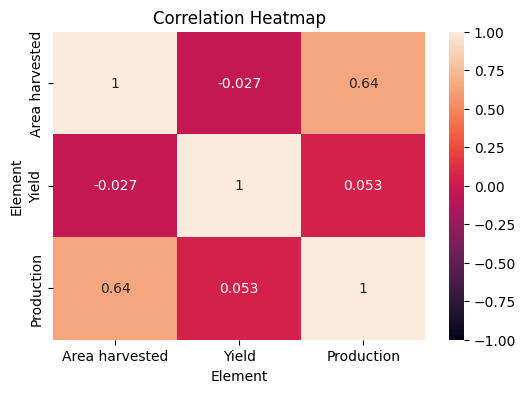

In [43]:
import seaborn as sns

# Plot heatmap for correlation
plt.figure(figsize=(6,4))
sns.heatmap(correlation_check.corr(), annot=True,vmax=1,vmin=-1)
plt.title("Correlation Heatmap")
plt.show()


**Comparative Analysis**

In [44]:
#Across Crops
com_analysis_yield=Cleaned_Data_final[['Item','Yield']]

total_yield=com_analysis_yield.groupby('Item')['Yield'].sum().reset_index()

high_yield=total_yield.sort_values(by="Yield", ascending=False)
low_yield=total_yield.sort_values(by="Yield", ascending=True)


In [45]:
fig_hyc=px.bar(high_yield.head(10),x='Item',y='Yield',color="Item", title="Highest yield Crops")
fig_hyc.show()

fig_lyc=px.bar(low_yield.head(10),x='Item',y='Yield',color="Item", title="Lowest yield Crops")
fig_lyc.show()

In [46]:
productive_analysis=Cleaned_Data_final[['Area','Production']]

In [47]:
total_Production=productive_analysis.groupby('Area')['Production'].sum().reset_index()
high_production=total_Production.sort_values(by="Production", ascending=False)

fig=px.bar(high_production.head(10),x='Area',y='Production',color="Area", title="Highly Productive Regions(2019-2023)")
fig.show()

fig_geo=px.scatter_geo(high_production,locations='Area',locationmode='country names',hover_data='Production',size='Production',color='Area',
                   title="Highly Productive Regions(2019-2023)", projection="orthographic")
fig_geo.show()

**Productivity Analysis**

In [48]:
yield_analysis=Cleaned_Data_final[['Area','Item','Yield']]

yield_analysis_total=yield_analysis.groupby(['Area','Item'])['Yield'].sum().reset_index()

In [49]:
productive_analysis_yield=yield_analysis_total.sort_values(by="Yield", ascending=False)
productive_analysis_yield.head(10)

fig = px.bar(productive_analysis_yield.head(10), x="Item", y="Yield", color="Area", title="High yield by Crop & Region")
fig.show()



In [50]:
# Productivity ratios
pd_data = Cleaned_Data_final[['Area', 'Item', 'Area harvested', 'Production']].copy()

# Calculate Productivity Ratio
pd_data['Productivity_Ratio'] = pd_data['Production'] / pd_data['Area harvested']
pd_data['Productivity_Percentage'] = pd_data['Productivity_Ratio'] * 100

fig_geo_pr = px.scatter_geo(pd_data, locations='Area', locationmode='country names',
                            hover_data=['Productivity_Percentage', 'Productivity_Ratio'], color='Area',
                            title="Crops and Regions Based on Productivity Ratio", projection="orthographic")
fig_geo_pr.show()


**Outlier Detection**

In [51]:
#Outlier Area harvested column
Q1_Area_harvested=Cleaned_Data_final['Area harvested'].quantile(0.25)
Q3_Area_harvested=Cleaned_Data_final['Area harvested'].quantile(0.75)

IQR_Area_harvested=Q3_Area_harvested-Q1_Area_harvested

print(f'Q1_Area_harvested:{Q1_Area_harvested}\nQ3_Area_harvested:{Q3_Area_harvested}\nIQR_Area_harvested:{IQR_Area_harvested}')

Q1_Area_harvested:473.5
Q3_Area_harvested:26790.0
IQR_Area_harvested:26316.5


In [52]:
#Outlier Yield column
Q1_Yield=Cleaned_Data_final['Yield'].quantile(0.25)
Q3_Yield=Cleaned_Data_final['Yield'].quantile(0.75)

IQR_Yield=Q3_Yield-Q1_Yield

print(f'Q1_Yield:{Q1_Yield}\nQ3_Yield:{Q3_Yield}\nIQR_Yield:{IQR_Yield}')

Q1_Yield:1873.0
Q3_Yield:14781.849999999999
IQR_Yield:12908.849999999999


In [53]:
#Outlier Production column
Q1_Production=Cleaned_Data_final['Production'].quantile(0.25)
Q3_Production=Cleaned_Data_final['Production'].quantile(0.75)

IQR_Production=Q3_Production-Q1_Production

print(f'Q1_Production:{Q1_Production}\nQ3_Production:{Q3_Production}\nIQR_Production:{IQR_Production}')

Q1_Production:2177.705
Q3_Production:164549.405
IQR_Production:162371.7


In [54]:
lb_AreaHarvested= Q1_Area_harvested - 1.5 * IQR_Area_harvested

up_AreaHarvested= Q3_Area_harvested + 1.5 * IQR_Area_harvested

print(f'Area harvested Outlier \n lower:{lb_AreaHarvested} \n upper:{up_AreaHarvested}')

Area harvested Outlier 
 lower:-39001.25 
 upper:66264.75


In [55]:
lb_yield= Q1_Yield - 1.5 * IQR_Yield

up_yield= Q3_Yield + 1.5 * IQR_Yield

print(f'Yield Outlier \n lower:{lb_yield} \n upper:{up_yield}')


Yield Outlier 
 lower:-17490.274999999998 
 upper:34145.125


In [56]:
lb_Production= Q1_Production - 1.5 * IQR_Production

up_Production= Q3_Production + 1.5 * IQR_Production

print(f'Production Outlier \n lower:{lb_Production} \n upper:{up_Production}')


Production Outlier 
 lower:-241379.84500000003 
 upper:408106.955


In [57]:
outlier_data=Cleaned_Data_final

In [58]:
# Identifying outliers in 'Area harvested'
outlier_data.loc[:, 'AreaHarvested_outlier'] = (outlier_data['Area harvested'] < lb_AreaHarvested) | (outlier_data['Area harvested'] > up_AreaHarvested)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11196\980651899.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
# Filtering columns Outlier == True
AreaHarvested_outlier=outlier_data[outlier_data['AreaHarvested_outlier']==True]
AreaHarvested_outlier

Element,Area,Item,Year,Area harvested,Yield,Production,AreaHarvested_outlier
2,Afghanistan,Wheat,2019,2334000.0,2095.1,4890000.00,True
3,Afghanistan,Wheat,2020,2668000.0,1943.4,5185000.00,True
4,Afghanistan,Wheat,2021,2046564.0,1963.1,4017657.00,True
5,Afghanistan,Wheat,2022,1859339.0,2045.3,3802895.00,True
6,Afghanistan,Wheat,2023,2003070.0,2146.7,4300000.00,True
...,...,...,...,...,...,...,...
81940,Zambia,"Beans, dry",2022,96448.0,624.8,60261.64,True
81941,Zambia,"Beans, dry",2023,131840.0,668.2,88095.30,True
81962,Zambia,"Seed cotton, unginned",2019,88748.0,817.0,72508.33,True
81963,Zambia,"Seed cotton, unginned",2020,68183.0,607.8,41440.80,True


In [60]:
# Identifying outliers in 'Yield'
outlier_data.loc[:, 'yield_outlier'] = (outlier_data['Yield'] < lb_yield) | (outlier_data['Yield'] > up_yield)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11196\2637587436.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
# Filtering columns Outlier == True
yield_outlier=outlier_data[outlier_data['yield_outlier']==True]

In [62]:
# Identifying outliers in 'Production'
outlier_data.loc[:, 'Production_outlier'] = (outlier_data['Production'] < lb_Production) | (outlier_data['Production'] > up_Production)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11196\2862888085.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
# Filtering columns Outlier == True
Production_outlier=outlier_data[outlier_data['Production_outlier']==True]

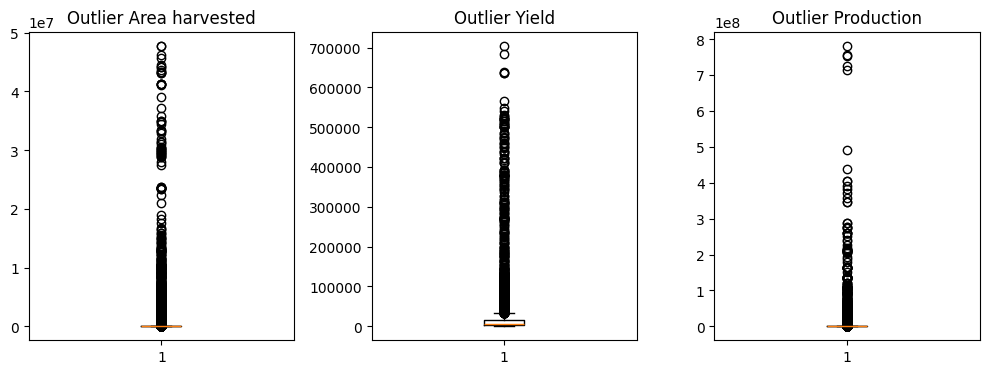

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].boxplot(outlier_data['Area harvested'])
axes[0].set_title('Outlier Area harvested')

axes[1].boxplot(outlier_data['Yield'])
axes[1].set_title('Outlier Yield')

axes[2].boxplot(outlier_data['Production'])
axes[2].set_title('Outlier Production')

plt.tight_layout()
plt.show()

**Machine Learning(Regression)**

In [65]:
final_data=Cleaned_Data_final[['Area','Item','Year','Area harvested','Yield','Production']]

In [66]:
from sklearn.preprocessing import LabelEncoder

lb_en_area = LabelEncoder()
lb_en_Item = LabelEncoder()

# Encoding columns with object datatype
final_data.loc[:, 'Area'] = lb_en_area.fit_transform(final_data['Area'])
final_data.loc[:, 'Item'] = lb_en_Item.fit_transform(final_data['Item'])


In [67]:
# Splitting data into Features and Target
x=final_data.drop(columns='Production',axis=1) #Features
y=final_data['Production'] #Target

In [68]:
# Splitting Features and Target for Training,Testing
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [69]:
#LinearRegression model
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [70]:
#DecisionTreeRegressor model
from sklearn.tree import  DecisionTreeRegressor
dtr=DecisionTreeRegressor()
dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [71]:
#KNeighborsRegressor model
from sklearn.neighbors import KNeighborsRegressor

KNN=KNeighborsRegressor(n_neighbors=5)
KNN.fit(x_train,y_train)

KNeighborsRegressor()

In [72]:
#Hyperparameter tuning
linear_param={'fit_intercept':[True,False]}

decision_param={"splitter":['best', 'random'],"max_depth":[None,5,10,15,20],"min_samples_split":[2,3,4,5,6,7,8,10]}

knn_param={'n_neighbors':[5,7,9,12,15,18,20],"weights":['uniform','distance']}


In [73]:
#Creating multiple models
from sklearn.model_selection import GridSearchCV

grid_search_lr=GridSearchCV(lr,linear_param,cv=5)
grid_search_dtr=GridSearchCV(dtr,decision_param,cv=5)
grid_search_KNN=GridSearchCV(KNN,knn_param,cv=5)

In [74]:
#Training multiple models
grid_search_lr.fit(x_train,y_train)
grid_search_dtr.fit(x_train,y_train)
grid_search_KNN.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 7, 9, 12, 15, 18, 20],
                         'weights': ['uniform', 'distance']})

In [75]:
#To find Best parameters for KNeighborsRegressor model
grid_search_KNN.best_estimator_

KNeighborsRegressor(n_neighbors=7, weights='distance')

In [76]:
KNN_grid=KNeighborsRegressor(n_neighbors=7, weights='distance')
KNN_grid.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=7, weights='distance')

In [77]:
#To find Best parameters for DecisionTreeRegressor model
grid_search_dtr.best_estimator_

DecisionTreeRegressor(min_samples_split=3, splitter='random')

In [78]:
grid_dtr=DecisionTreeRegressor(max_depth=15,  min_samples_split=3, splitter='random')
grid_dtr.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=15, min_samples_split=3, splitter='random')

In [79]:
#DecisionTreeRegressor model 
grid_dtr1=DecisionTreeRegressor()
grid_dtr1.fit(x_train,y_train)

DecisionTreeRegressor()

In [80]:
#RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor
rfc=RandomForestRegressor()
rfc.fit(x_train,y_train)

RandomForestRegressor()

In [81]:
# Error metrics and Scores of the different models
from sklearn.metrics import mean_absolute_error

y_pred_lr=lr.predict(x_test)
lr_score=lr.score(x_test,y_test)
linear_mae=mean_absolute_error(y_test,y_pred_lr)

y_pred_dtr=dtr.predict(x_test)
dtr_score=dtr.score(x_test,y_test)
dtr_mae=mean_absolute_error(y_test,y_pred_dtr)

y_pred_knn=KNN.predict(x_test)
KNN_score=KNN.score(x_test,y_test)
knn_mae=mean_absolute_error(y_test,y_pred_knn)


y_pred_KNN_grid=KNN_grid.predict(x_test)
KNN_grid_score=KNN_grid.score(x_test,y_test)
KNN_grid_mae=mean_absolute_error(y_test,y_pred_KNN_grid)


y_pred_grid_dtr=grid_dtr.predict(x_test)
grid_dtr_score=grid_dtr.score(x_test,y_test)
grid_dtr_mae=mean_absolute_error(y_test,y_pred_grid_dtr)

y_pred_grid_dtr1=grid_dtr1.predict(x_test)
grid_dtr1_score=grid_dtr1.score(x_test,y_test)
grid_dtr1_mae=mean_absolute_error(y_test,y_pred_grid_dtr1)

y_pred_rfc=rfc.predict(x_test)
rfc_score=rfc.score(x_test,y_test)
rfc_mae=mean_absolute_error(y_test,y_pred_rfc)


print(f' Linear Regression Score:{lr_score},Linear Regression mae : {linear_mae} \n\n KNN score : {KNN_score},KNN mae : {knn_mae} \n\n  Decition tree score : {dtr_score},Decition tree mae : {dtr_mae} \n\n  KNN grid score: {KNN_grid_score},KNN grid mae: {KNN_grid_mae} \n\n  Decition tree grid score : {grid_dtr_score},Decition tree grid mae : {grid_dtr_mae} \n\n  Decition tree grid1 score : {grid_dtr1_score},Decition tree grid1 mae : {grid_dtr1_mae} \n\n  Random forest score : {rfc_score},Random forest mae : {rfc_mae}')


 Linear Regression Score:0.30175505707473627,Linear Regression mae : 1275402.796046397 

 KNN score : 0.5186487901870152,KNN mae : 518167.7327561138 

  Decition tree score : 0.7957408132816917,Decition tree mae : 128410.5830113384 

  KNN grid score: 0.5858946985224486,KNN grid mae: 457500.1556412311 

  Decition tree grid score : 0.9971955218922344,Decition tree grid mae : 96791.17717340121 

  Decition tree grid1 score : 0.8095282332584466,Decition tree grid1 mae : 131123.89075144508 

  Random forest score : 0.9137361600413035,Random forest mae : 92801.78377315472


**Model and Encoder Memory Files**

In [82]:
import pickle

In [83]:
with open("RandomForestRegressor.pkl",'wb') as RFC_file:
    pickle.dump(rfc,RFC_file)

In [84]:

with open("LabelEncoder_Area.pkl",'wb') as encoder_file:
    pickle.dump(lb_en_area,encoder_file)

In [85]:
with open("LabelEncoder_Item.pkl",'wb') as encoder_file:
    pickle.dump(lb_en_Item,encoder_file)

In [86]:
# save DF as csv
Cleaned_Data_final.to_csv('Cleaned_Data_final.csv', index=False)